In [29]:
import numpy as np
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [8]:
class MWEMFixed:
    def __init__(self, num_iterations: int = 20, epsilon: float = 1.0):
        self.num_iterations = num_iterations
        self.epsilon = epsilon
        self.epsilon_per_iter = epsilon / num_iterations
    
    def generate_synthetic_data(
        self,
        real_data: np.ndarray,
        feature_ranges: List[int],
        output_size: int
    ) -> np.ndarray:
        n_real, n_features = real_data.shape
        all_combinations = list(itertools.product(
            *[range(r) for r in feature_ranges]
        ))
        n_combinations = len(all_combinations)
        
        print(f"MWEM (Fixed): {output_size} synthetic samples")
        print(f"Privacy: ε={self.epsilon} ({self.num_iterations} iterations)")
        print(f"Possible combinations: {n_combinations}\n")
        weights = np.ones(n_combinations) / n_combinations
        queries = self._generate_queries(n_features, feature_ranges)
        for t in range(self.num_iterations):
            worst_query, max_error = self._find_worst_query(
                queries, real_data, weights, all_combinations
            )
            
            real_answer = self._evaluate_query_on_data(worst_query, real_data)
            noisy_answer = real_answer + np.random.laplace(
                0, 1.0 / self.epsilon_per_iter
            )
            weights = self._multiplicative_update(
                weights, all_combinations, worst_query, 
                noisy_answer, n_real
            )
            weights = weights / weights.sum()
            
            if t % 5 == 0 or t == self.num_iterations - 1:
                synth_answer = self._evaluate_query_on_weights(
                    worst_query, weights, all_combinations, n_real
                )
                print(f"Iter {t+1:2d}: Query {worst_query}, "
                      f"Real={real_answer:.0f}, Noisy={noisy_answer:.0f}, "
                      f"Synth={synth_answer:.0f}")
        
        synthetic_data = self._sample_from_weights(
            weights, all_combinations, output_size, n_features
        )
        
        return synthetic_data
    
    def _generate_queries(self, n_features: int, feature_ranges: List[int]):
        queries = []
        for f in range(n_features):
            for v in range(feature_ranges[f]):
                queries.append([(f, v)])
        for f1, f2 in itertools.combinations(range(n_features), 2):
            for v1 in range(feature_ranges[f1]):
                for v2 in range(feature_ranges[f2]):
                    queries.append([(f1, v1), (f2, v2)])
        
        return queries
    
    def _evaluate_query_on_data(self, query: List[Tuple], data: np.ndarray) -> float:
        mask = np.ones(len(data), dtype=bool)
        for feature_idx, value in query:
            mask &= (data[:, feature_idx] == value)
        return np.sum(mask)
    
    def _evaluate_query_on_weights(
        self, 
        query: List[Tuple], 
        weights: np.ndarray,
        all_combinations: List,
        scale: float
    ) -> float:
        total = 0.0
        for i, combo in enumerate(all_combinations):
            satisfies = all(combo[f] == v for f, v in query)
            if satisfies:
                total += weights[i]
        return total * scale
    
    def _find_worst_query(
        self,
        queries: List,
        real_data: np.ndarray,
        weights: np.ndarray,
        all_combinations: List
    ) -> Tuple[List, float]:
        n_real = len(real_data)
        max_error = -1
        worst_query = None
        
        for query in queries:
            real_count = self._evaluate_query_on_data(query, real_data)
            synth_count = self._evaluate_query_on_weights(
                query, weights, all_combinations, n_real
            )
            error = abs(real_count - synth_count)
            
            if error > max_error:
                max_error = error
                worst_query = query
        
        return worst_query, max_error
    
    def _multiplicative_update(
        self,
        weights: np.ndarray,
        all_combinations: List,
        query: List[Tuple],
        target_count: float,
        dataset_size: float
    ) -> np.ndarray:
        new_weights = weights.copy()
        
        current_count = self._evaluate_query_on_weights(
            query, weights, all_combinations, dataset_size
        )
        
        eta = 2.0
        for i, combo in enumerate(all_combinations):
            satisfies = all(combo[f] == v for f, v in query)
            
            if satisfies:
                error = (target_count - current_count) / dataset_size
                new_weights[i] *= np.exp(eta * error)
        
        return new_weights
    
    def _sample_from_weights(
        self,
        weights: np.ndarray,
        all_combinations: List,
        n_samples: int,
        n_features: int
    ) -> np.ndarray:
        indices = np.random.choice(
            len(all_combinations),
            size=n_samples,
            p=weights
        )
        data = np.zeros((n_samples, n_features), dtype=int)
        for i, idx in enumerate(indices):
            data[i] = all_combinations[idx]
        
        return data


In [26]:
from urllib.request import urlopen
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

try:
    df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
    df = df.dropna()
    
    df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=[0, 1, 2])
    
    education_mapping = {
        'Preschool': 0, '1st-4th': 0, '5th-6th': 0, '7th-8th': 0, '9th': 0,
        '10th': 0, '11th': 0, '12th': 0, 'HS-grad': 0,
        'Some-college': 1, 'Assoc-voc': 1, 'Assoc-acdm': 1,
        'Bachelors': 2, 'Masters': 2, 'Doctorate': 2, 'Prof-school': 2
    }
    df['education_level'] = df['education'].map(education_mapping)
    
    workclass_mapping = {
        'Private': 0,
        'Local-gov': 1, 'State-gov': 1, 'Federal-gov': 1,
        'Self-emp-not-inc': 2, 'Self-emp-inc': 2
    }
    df['workclass_group'] = df['workclass'].map(workclass_mapping)
    
    clean_df = df[['age_group', 'education_level', 'workclass_group']].dropna()
    real_data = clean_df.values.astype(int)
    
    print(f"✓ Loaded {len(real_data)} records\n")
    
except Exception as e:
    print(f"Could not load data: {e}")

✓ Loaded 30704 records



In [22]:
def summarise_results(synthetic_data):
    feature_names = ["Age Group", "Education", "Workclass"]
    value_names = [
    ["Young", "Middle", "Senior"],
    ["No College", "Some College", "Bachelors+"],
    ["Private", "Government", "Self-Employed"]
    ]
    
    total_error = 0
    count = 0
    
    for feature_idx in range(3):
        print(f"\n{feature_names[feature_idx]}:")
        print("-" * 70)
        for value_idx in range(3):
            real_pct = 100 * np.sum(real_data[:, feature_idx] == value_idx) / len(real_data)
            synth_pct = 100 * np.sum(synthetic_data[:, feature_idx] == value_idx) / len(synthetic_data)
            error = abs(real_pct - synth_pct)
            total_error += error
            count += 1
            
            print(f"  {value_names[feature_idx][value_idx]:15} - "
                  f"Real: {real_pct:5.1f}%  Synth: {synth_pct:5.1f}%  "
                  f"Error: {error:4.1f}%")
    
    avg_error = total_error / count
    print(f"Average 1-way marginal error: {avg_error:.2f}%")
    print(f"Privacy guarantee: ε={mwem.epsilon} differential privacy")

In [23]:
mwem1 = MWEMFixed(num_iterations=20, epsilon=2.0)
synthetic_data1 = mwem.generate_synthetic_data(
    real_data,
    feature_ranges=[3, 3, 3],
    output_size=len(real_data)
)
summarise_results(synthetic_data1)

MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (50 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22824, Synth=16325
Iter  6: Query [(1, 0), (2, 0)], Real=10985, Noisy=10776, Synth=9281
Iter 11: Query [(1, 0), (2, 0)], Real=10985, Noisy=11265, Synth=10423
Iter 16: Query [(1, 1), (2, 0)], Real=6828, Noisy=6711, Synth=6152
Iter 21: Query [(0, 0), (2, 0)], Real=8337, Noisy=8307, Synth=7890
Iter 26: Query [(0, 0), (2, 2)], Real=473, Noisy=393, Synth=1019
Iter 31: Query [(0, 0), (2, 2)], Real=473, Noisy=344, Synth=928
Iter 36: Query [(0, 0), (2, 2)], Real=473, Noisy=428, Synth=890
Iter 41: Query [(0, 2), (1, 0)], Real=2964, Noisy=2951, Synth=2609
Iter 46: Query [(0, 1), (1, 2)], Real=4545, Noisy=4572, Synth=4246
Iter 50: Query [(0, 2), (1, 0)], Real=2964, Noisy=2918, Synth=2612

Age Group:
----------------------------------------------------------------------
  Young           - Real:  31.7%  Synth:  32.6%  Error:  0.9%
  Middle          - Real:  49.

In [24]:
mwem2 = MWEMFixed(num_iterations=20, epsilon=1.0)
synthetic_data2 = mwem.generate_synthetic_data(
    real_data,
    feature_ranges=[3, 3, 3],
    output_size=len(real_data)
)
summarise_results(synthetic_data2)

MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (50 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22722, Synth=16274
Iter  6: Query [(1, 0), (2, 0)], Real=10985, Noisy=10553, Synth=9036
Iter 11: Query [(0, 0), (2, 0)], Real=8337, Noisy=8392, Synth=7360
Iter 16: Query [(1, 2), (2, 0)], Real=4883, Noisy=5128, Synth=5620
Iter 21: Query [(0, 0), (2, 0)], Real=8337, Noisy=8066, Synth=7794
Iter 26: Query [(1, 1), (2, 0)], Real=6828, Noisy=6843, Synth=6419
Iter 31: Query [(0, 2), (2, 0)], Real=3587, Noisy=3539, Synth=3966
Iter 36: Query [(0, 2), (2, 0)], Real=3587, Noisy=3517, Synth=3916
Iter 41: Query [(0, 2), (1, 0)], Real=2964, Noisy=3064, Synth=2624
Iter 46: Query [(0, 0), (1, 2)], Real=1779, Noisy=1729, Synth=2116
Iter 50: Query [(0, 0), (2, 2)], Real=473, Noisy=432, Synth=805

Age Group:
----------------------------------------------------------------------
  Young           - Real:  31.7%  Synth:  32.3%  Error:  0.6%
  Middle          - Real:  4

In [25]:
mwem3 = MWEMFixed(num_iterations=50, epsilon=0.5)
synthetic_data3 = mwem.generate_synthetic_data(
    real_data,
    feature_ranges=[3, 3, 3],
    output_size=len(real_data)
)
summarise_results(synthetic_data3)

MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (50 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22776, Synth=16301
Iter  6: Query [(1, 0), (2, 0)], Real=10985, Noisy=11074, Synth=9285
Iter 11: Query [(1, 0), (2, 0)], Real=10985, Noisy=11061, Synth=10345
Iter 16: Query [(0, 1)], Real=15182, Noisy=15262, Synth=14765
Iter 21: Query [(1, 2), (2, 0)], Real=4883, Noisy=4869, Synth=5372
Iter 26: Query [(0, 2), (2, 0)], Real=3587, Noisy=3513, Synth=4010
Iter 31: Query [(0, 2), (1, 0)], Real=2964, Noisy=2745, Synth=2517
Iter 36: Query [(0, 0), (2, 2)], Real=473, Noisy=594, Synth=894
Iter 41: Query [(0, 1), (1, 2)], Real=4545, Noisy=4524, Synth=4193
Iter 46: Query [(0, 0), (2, 2)], Real=473, Noisy=272, Synth=840
Iter 50: Query [(0, 0), (2, 2)], Real=473, Noisy=500, Synth=823

Age Group:
----------------------------------------------------------------------
  Young           - Real:  31.7%  Synth:  32.8%  Error:  1.1%
  Middle          - Real:  49.4%  Sy

In [36]:
def test_mwem_parameters(real_data, num_tests=20):
    test_params = [
        (5, 0.5), (10, 0.5), (20, 0.5), (50, 0.5),
        (5, 1.0), (10, 1.0), (20, 1.0), (50, 1.0),
        (5, 2.0), (10, 2.0), (20, 2.0), (50, 2.0),
        (5, 5.0), (10, 5.0), (20, 5.0), (50, 5.0),
        (5, 10.0), (10, 10.0), (20, 10.0), (50, 10.0),
        (100, 0.5), (100, 1.0), (100, 2.0), (100, 5.0), (100, 10.0),
    ]
    results = []
    for iters, eps in test_params:
        print(f"Testing: iterations={iters}, epsilon={eps}...", end=" ")
        
        mwem = MWEMFixed(num_iterations=iters, epsilon=eps)
        synthetic = mwem.generate_synthetic_data(
            real_data, 
            feature_ranges=[3, 3, 3],
            output_size=len(real_data)
        )
        total_error = 0
        count = 0
        for f_idx in range(3):
            for v_idx in range(3):
                real_pct = 100 * np.sum(real_data[:, f_idx] == v_idx) / len(real_data)
                synth_pct = 100 * np.sum(synthetic[:, f_idx] == v_idx) / len(synthetic)
                total_error += abs(real_pct - synth_pct)
                count += 1
        
        avg_error = total_error / count
        results.append({
            'iterations': iters,
            'epsilon': eps,
            'avg_error': avg_error
        })
        print(f"Error: {avg_error:.2f}% \n")
        print("="*70)
    
    return pd.DataFrame(results)


In [37]:
def visualize_mwem_results(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    pivot = df.pivot(index='iterations', columns='epsilon', values='avg_error')
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Avg Error (%)'}, ax=axes[0])
    axes[0].set_title('MWEM Error: Iterations vs Epsilon', fontweight='bold')
    axes[0].set_xlabel('Privacy Budget (ε)')
    axes[0].set_ylabel('Number of Iterations')
    for eps in df['epsilon'].unique():
        subset = df[df['epsilon'] == eps]
        axes[1].plot(subset['iterations'], subset['avg_error'], 
                    marker='o', label=f'ε={eps}')
    axes[1].set_xlabel('Number of Iterations')
    axes[1].set_ylabel('Average Error (%)')
    axes[1].set_title('Error vs Iterations (by ε)', fontweight='bold')
    axes[1].legend(title='Privacy Budget')
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mwem_parameter_sweep.png', dpi=150, bbox_inches='tight')
    plt.show()
    best = df.loc[df['avg_error'].idxmin()]
    print("\n" + "="*70)
    print("BEST CONFIGURATION:")
    print(f"  Iterations: {best['iterations']:.0f}")
    print(f"  Epsilon: {best['epsilon']:.1f}")
    print(f"  Avg Error: {best['avg_error']:.2f}%")
    print("="*70)


Testing: iterations=5, epsilon=0.5... MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (5 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22704, Synth=16265
Iter  5: Query [(0, 2)], Real=5778, Noisy=5760, Synth=7764
Error: 4.87% 

Testing: iterations=10, epsilon=0.5... MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (10 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22689, Synth=16257
Iter  6: Query [(1, 0), (2, 0)], Real=10985, Noisy=11002, Synth=9282
Iter 10: Query [(0, 0), (2, 0)], Real=8337, Noisy=8283, Synth=7240
Error: 2.13% 

Testing: iterations=20, epsilon=0.5... MWEM (Fixed): 30704 synthetic samples
Privacy: ε=0.5 (20 iterations)
Possible combinations: 27

Iter  1: Query [(2, 0)], Real=22696, Noisy=22751, Synth=16288
Iter  6: Query [(1, 0), (2, 0)], Real=10985, Noisy=11030, Synth=9267
Iter 11: Query [(1, 0), (2, 0)], Real=10985, Noisy=10960, Synth=10282
Iter 16: Query [(0, 0), (2, 0)], Real=8337, Noi

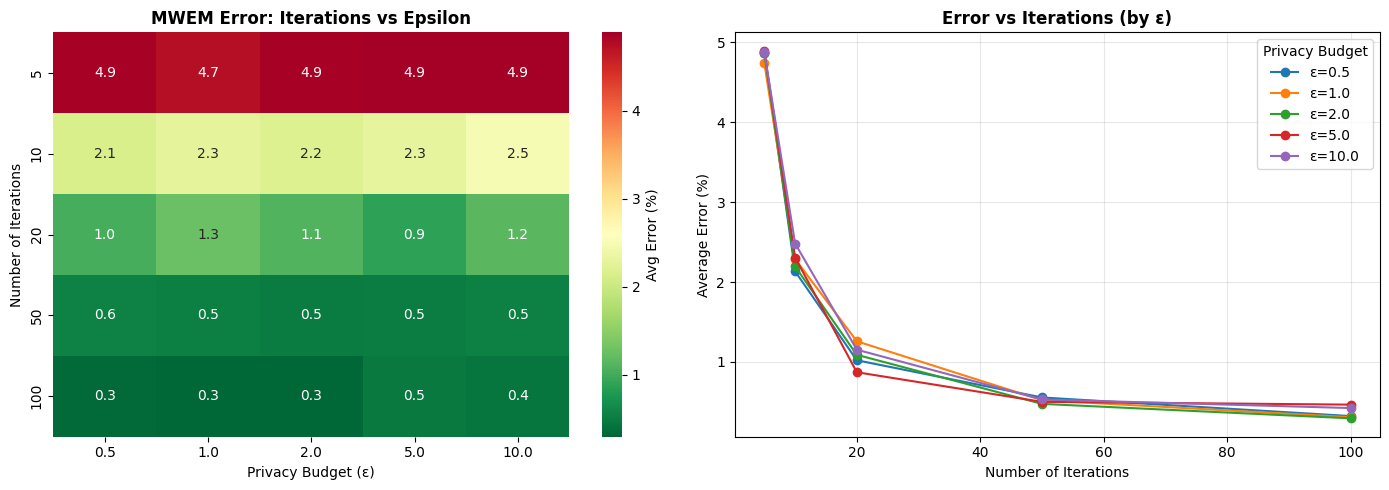


BEST CONFIGURATION:
  Iterations: 100
  Epsilon: 2.0
  Avg Error: 0.29%

Results saved to mwem_results.csv


In [38]:
results_df = test_mwem_parameters(real_data)
visualize_mwem_results(results_df)
results_df.to_csv('mwem_results.csv', index=False)
print("\nResults saved to mwem_results.csv")